## <center> **SIREN**: Sinusoidal Representation Networks
###### <center> _Sitzmann, V., Martel, J., Bergman, A., Lindell, D., and Wetzstein, G. 2020. [Implicit Neural Representations with Periodic Activation Functions](https://www.vincentsitzmann.com/siren/). In Proc. NeurIPS._

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [3]:
from sklearn import preprocessing

### Get the Audio File

In [4]:
!wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav

--2024-09-19 19:25:19--  https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
Resolving www.vincentsitzmann.com (www.vincentsitzmann.com)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to www.vincentsitzmann.com (www.vincentsitzmann.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232886 (1.2M) [audio/wav]
Saving to: 'gt_bach.wav'

gt_bach.wav         100%[===================>]   1.17M  --.-KB/s    in 0.06s   

2024-09-19 19:25:19 (19.6 MB/s) - 'gt_bach.wav' saved [1232886/1232886]



In [5]:
from IPython.display import Audio
Audio('gt_bach.wav')

In [6]:
import torchaudio
audio, sr = torchaudio.load('./gt_bach.wav')

$$ \text{Sampling Frequency} = \frac{\text{No. of Samples}}{\text{Time Taken}} $$

In [7]:
sr

44100

In [8]:
print(audio.shape)
audio = audio[0]

torch.Size([1, 308207])


In [9]:
tm = audio.shape[0] / sr
print(f"Audio length: {tm} seconds")

Audio length: 6.988820861678004 seconds


In [10]:
audio

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0473, 0.0297, 0.0168])

In [11]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

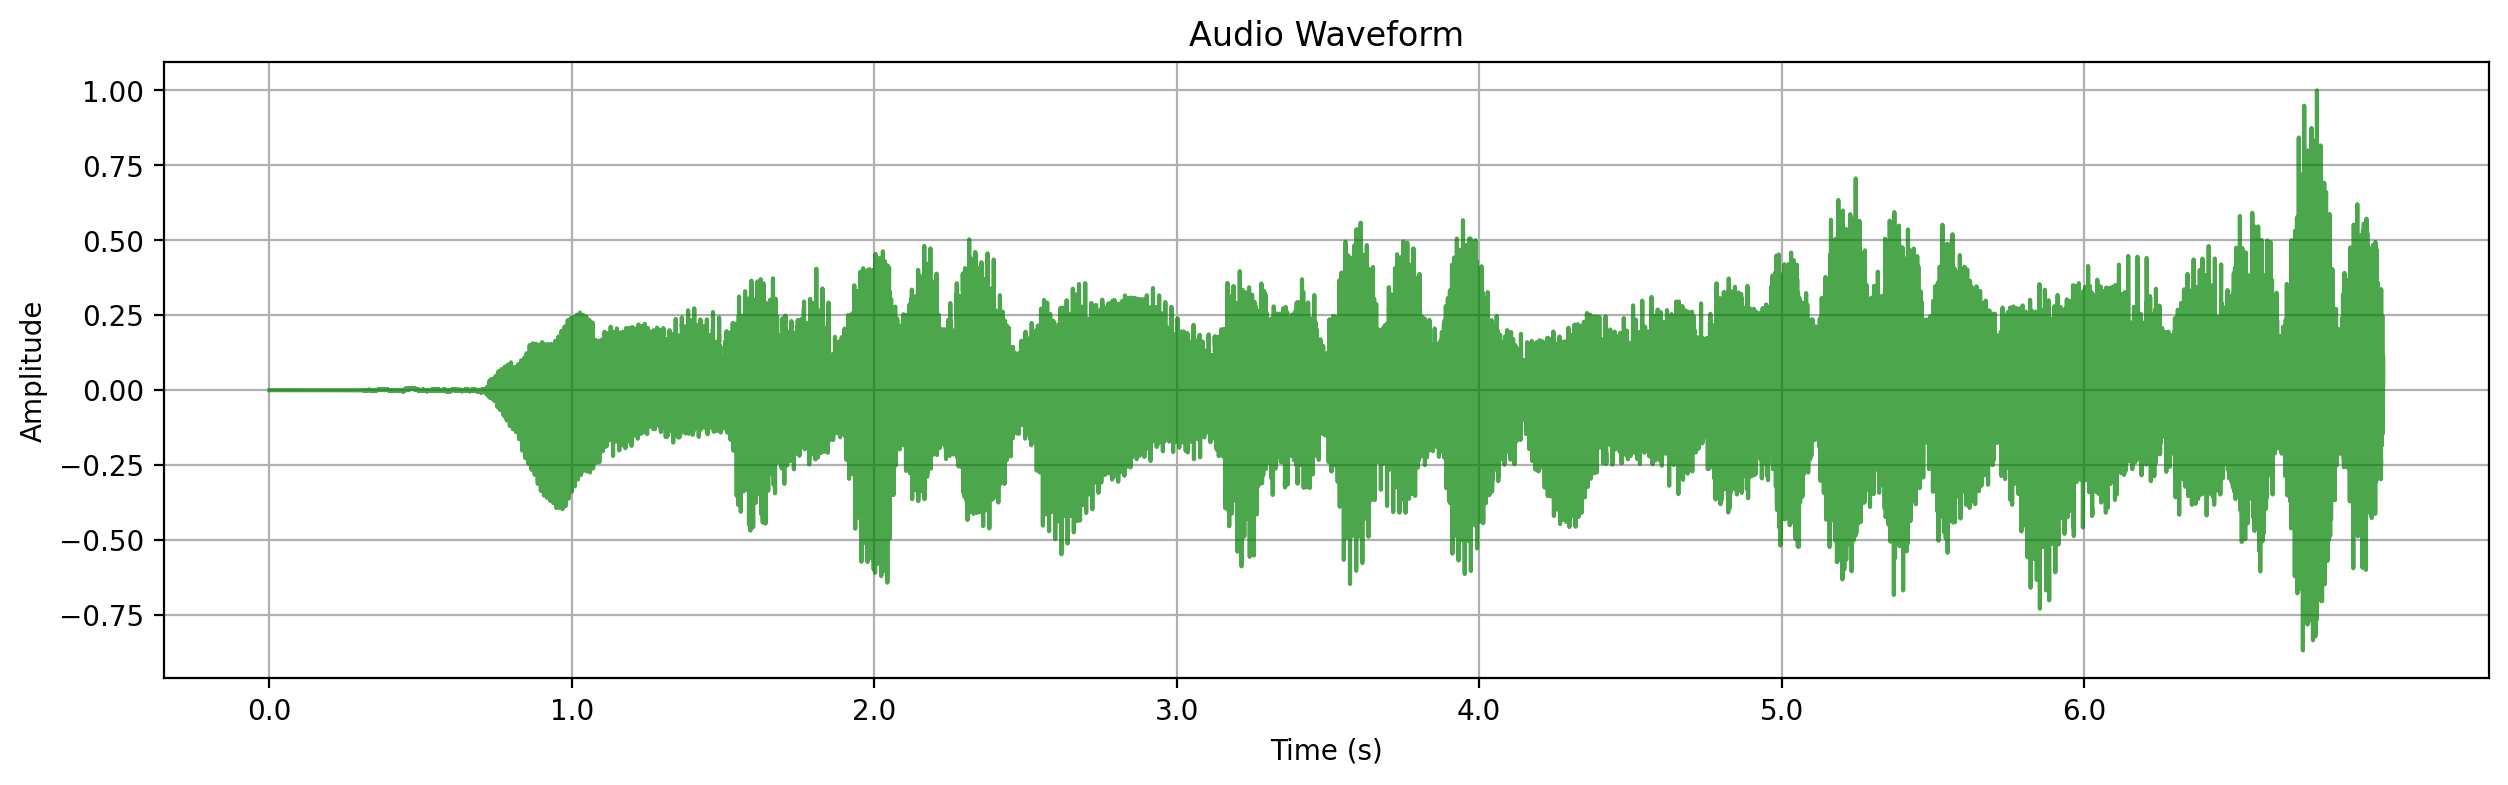

In [12]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

### Using the last 5 seconds of the Audio

In [13]:
audio = audio[-5 * sr:]
print(audio.shape)
print(audio)

torch.Size([220500])
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])


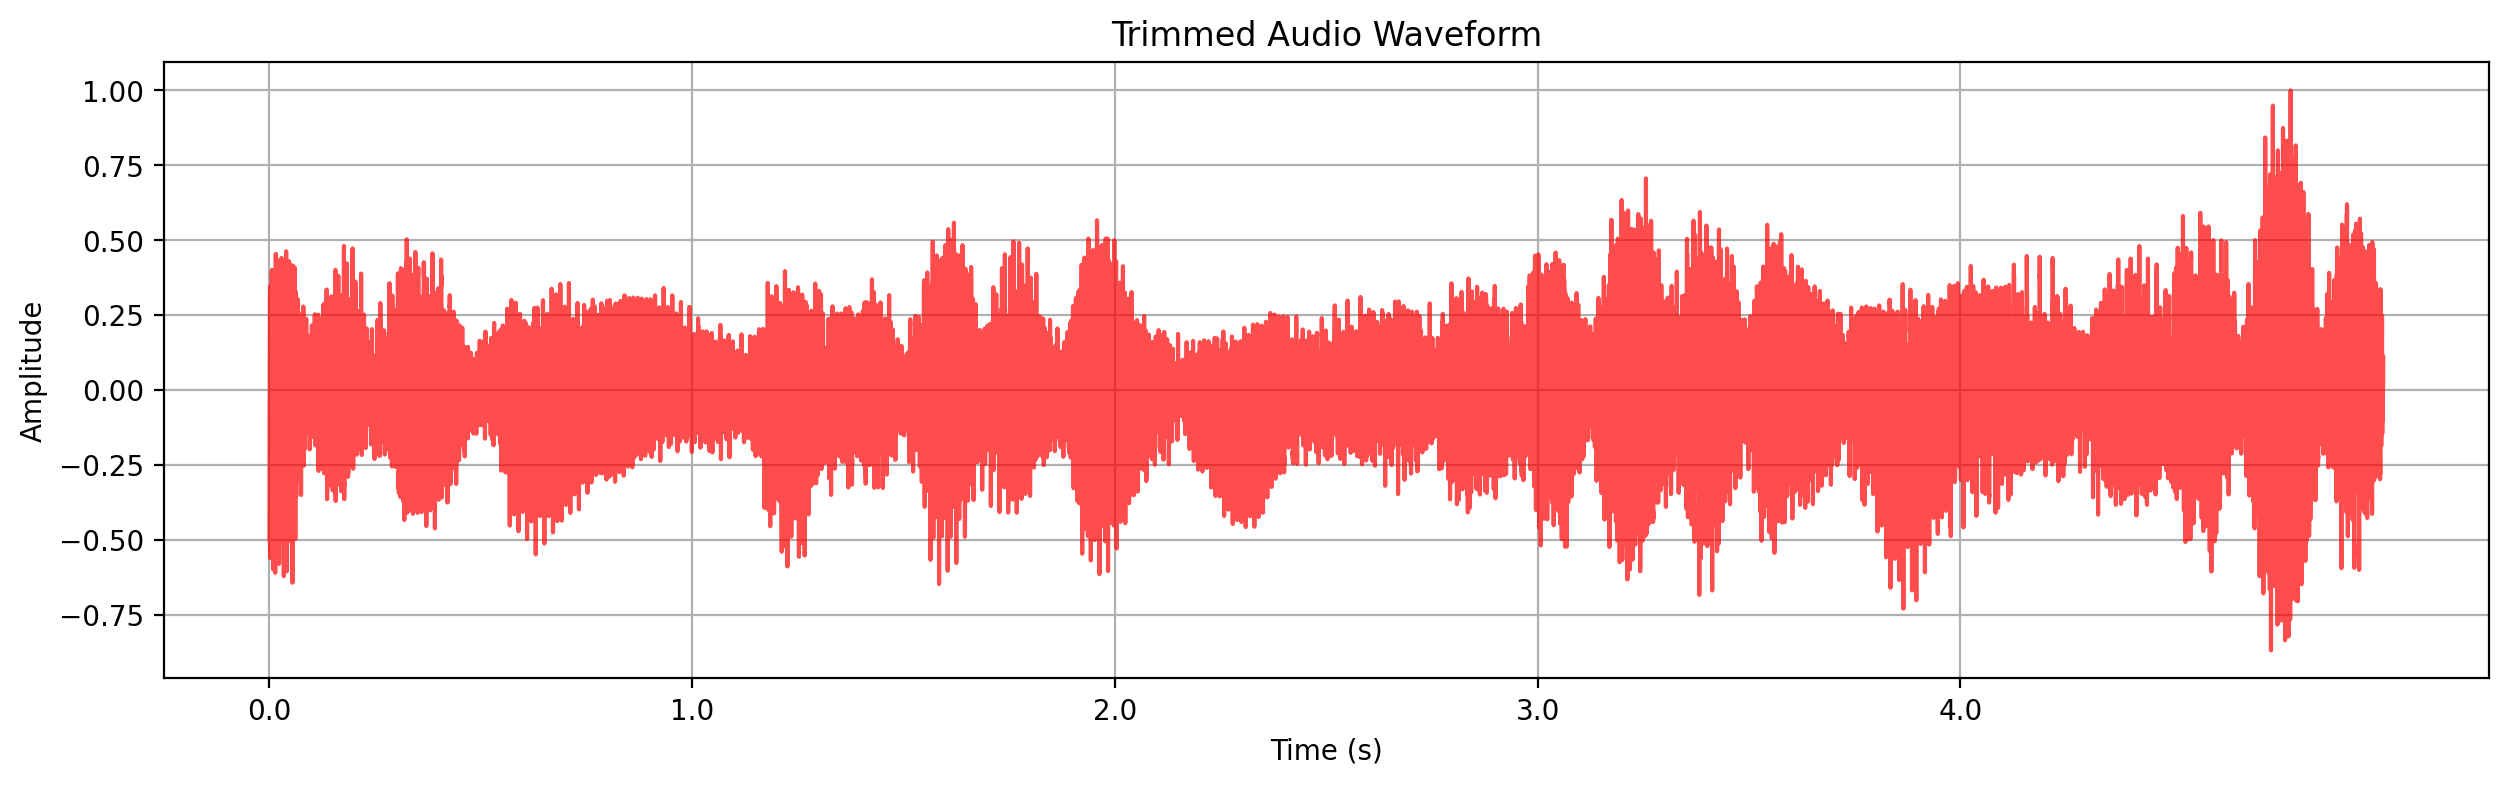

In [14]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [15]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [16]:
Audio(audio, rate = sr)

### Gaussian Kernel and Random Fourier Features

#### The Gaussian Kernel
$$ K(\textbf{x}, \textbf{x}') = \exp{(-\gamma \lVert \textbf{x} - \textbf{x}' \rVert^2)}, \gamma = \frac{1}{2\sigma^2}$$

#### Since this is infinte dimensional, it can approximated with the **Fourier Transform** of this kernel
###### _(Rahimi, A., & Recht, B. (2007). [Random features for large-scale kernel machines](https://papers.nips.cc/paper_files/paper/2007/hash/013a006f03dbc5392effeb8f18fda755-Abstract.html). Advances in Neural Information Processing Systems, 1177–1184.)_

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2 I)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$

In [17]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [18]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 5000])
tensor([[ 0.0088, -0.0179, -0.0190,  ..., -0.0196,  0.0071, -0.0053],
        [ 0.0074, -0.0186, -0.0190,  ..., -0.0197,  0.0080, -0.0069],
        [ 0.0058, -0.0191, -0.0190,  ..., -0.0197,  0.0088, -0.0083],
        ...,
        [-0.0103, -0.0194, -0.0145,  ...,  0.0059, -0.0014, -0.0125],
        [-0.0089, -0.0189, -0.0145,  ...,  0.0064, -0.0004, -0.0137],
        [-0.0074, -0.0183, -0.0144,  ...,  0.0068,  0.0005, -0.0148]])


## Fit a Linear Model over this expanded feature domain
### $\textbf{X}_{(88200, 5000)}, \textbf{y}_{(88200, )}$

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


### On saving the model weights and sound file

In [20]:
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

In [21]:
print(pred_audio)
print(audio)
print(audio.shape)

[-0.16334473 -0.1569076  -0.15307097 ...  0.31754646  0.32347474
  0.3276771 ]
tensor([-0.4993, -0.4846, -0.4692,  ...,  0.0473,  0.0297,  0.0168])
torch.Size([220500])


### Reconstruction Losses ($L_1$ and $L_2$)
$$ L_1 = \lVert \text{Reconstructed} - \text{Original} \rVert_1 $$
$$ L_2 = \lVert \text{Reconstructed} - \text{Original} \rVert_2 $$

In [22]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(61.59871, 22696.475)

## Reconstructed Audio

In [23]:
Audio(pred_audio, rate = sr)

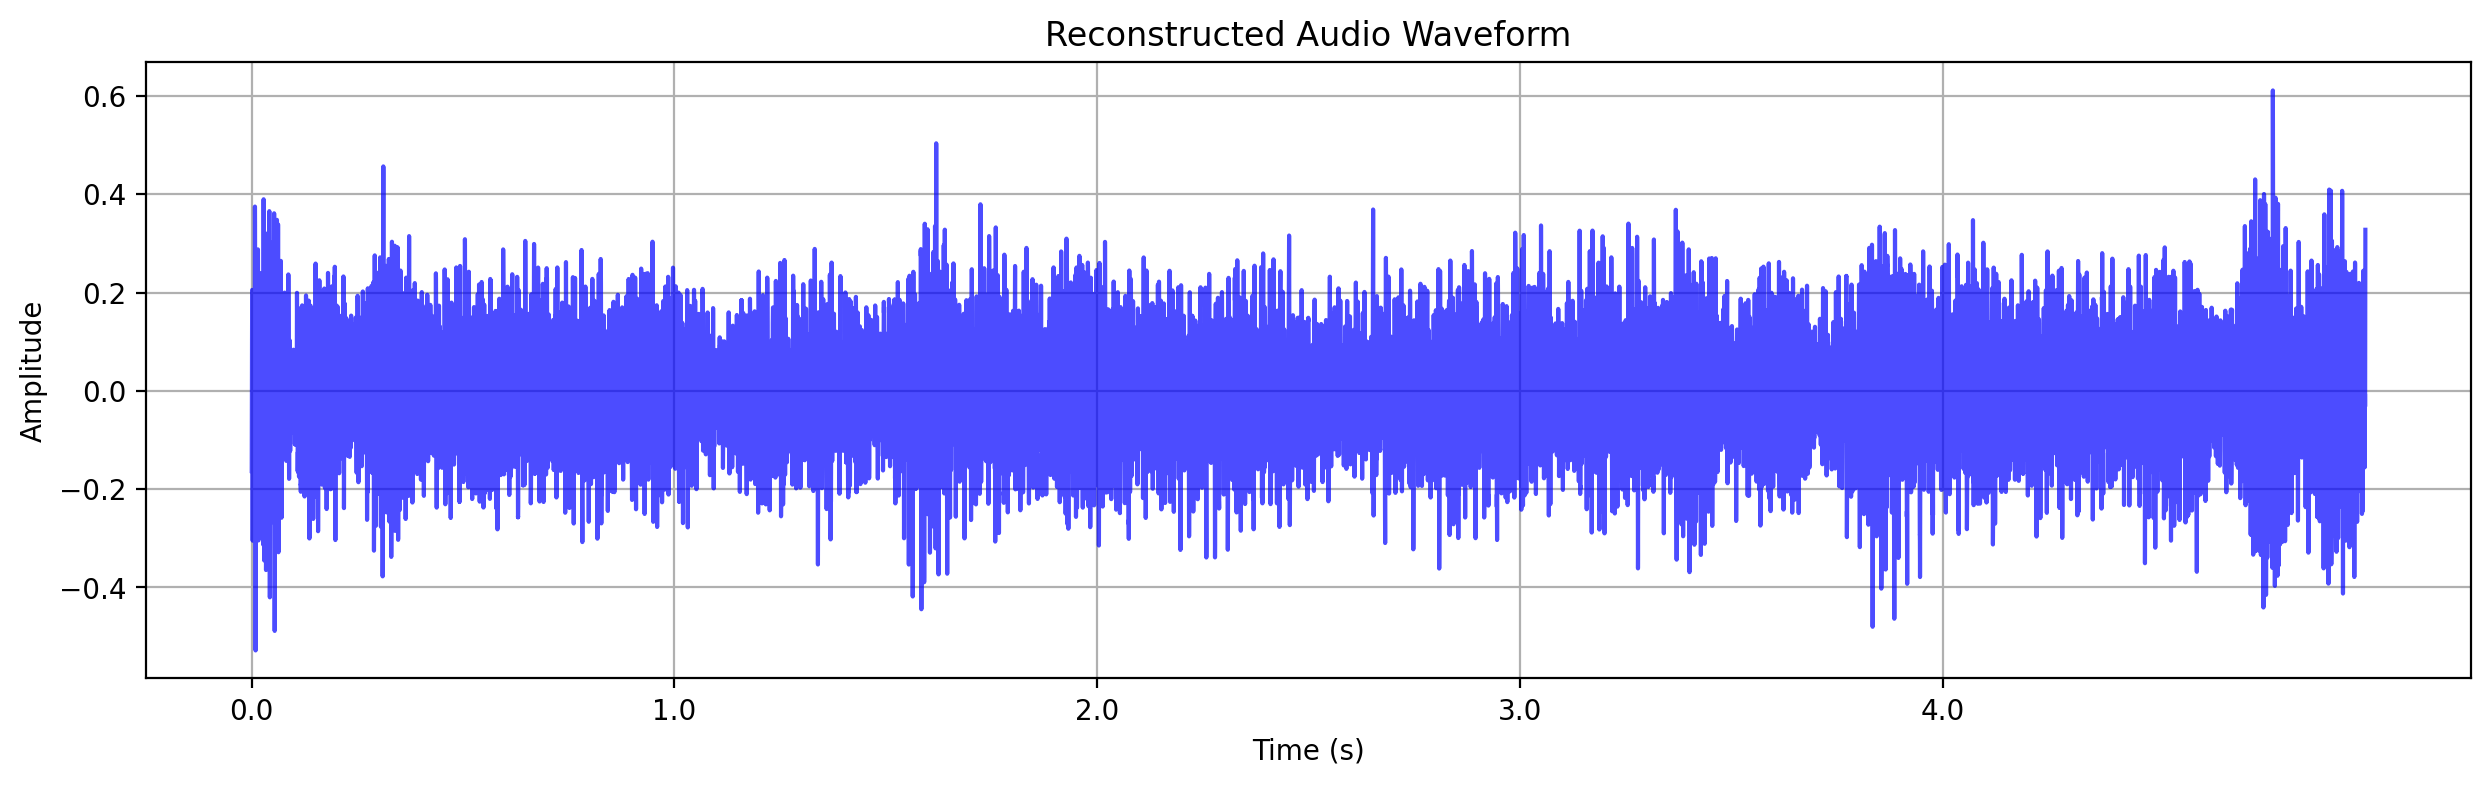

In [24]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

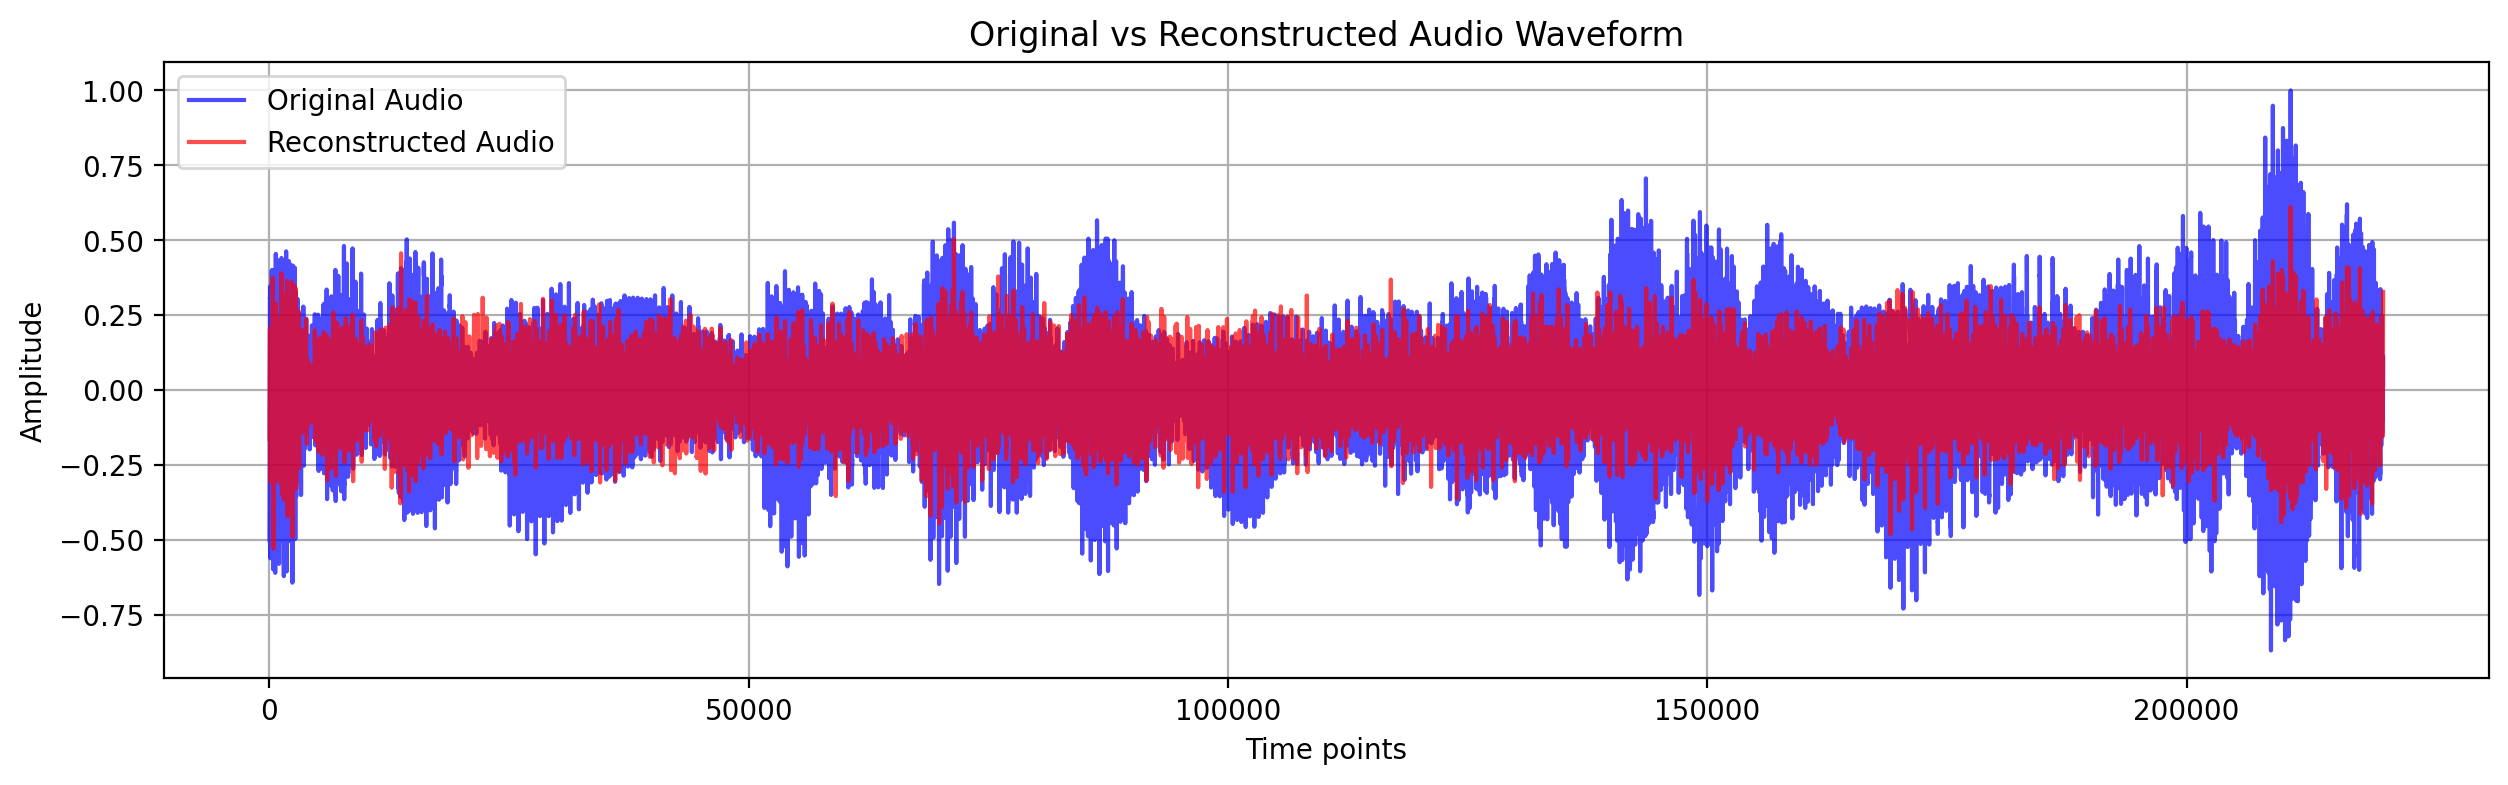

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time points')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [35]:
audio_np=audio.numpy()

In [36]:

scaler_1 = preprocessing.MinMaxScaler().fit(audio_np.reshape(-1, 1))
scaler_1
scaler_2 = preprocessing.MinMaxScaler().fit(pred_audio.reshape(-1, 1))
scaler_2

MinMaxScaler()

In [37]:
print(audio_np)
print(pred_audio)

[-0.49928397 -0.48463318 -0.46921128 ...  0.04731218  0.02968716
  0.01679885]
[-0.16334473 -0.1569076  -0.15307097 ...  0.31754646  0.32347474
  0.3276771 ]


In [39]:
#Calculating RMSE on Amplitude

rmse= np.sqrt(np.mean((pred_audio - audio_np) ** 2))
print("RMSE: ",rmse)

RMSE:  0.13117993


In [40]:
audio_np_normalized = scaler_1.transform(audio_np.reshape(-1, 1)).reshape(audio_np.shape)

pred_audio_normalized = scaler_2.transform(pred_audio.reshape(-1, 1)).reshape(pred_audio.shape)

print(audio_np_normalized)
print(pred_audio_normalized)


[0.19751778 0.20535952 0.21361399 ... 0.49007988 0.4806462  0.47374782]
[0.32036582 0.32601374 0.32937998 ... 0.7422987  0.7475002  0.7511873 ]


In [41]:
#Calculating RMSE ON Normalized data

rmse= np.sqrt(np.mean((audio_np_normalized - pred_audio_normalized) ** 2))
print("RMSE: ",rmse)

RMSE:  0.08066496


In [42]:
#Calculating SNR ON Normalized data
noise_1 = audio_np_normalized - pred_audio_normalized
signal_power_1 = np.mean(audio_np_normalized ** 2)
noise_power_1 = np.mean(noise_1 ** 2)

    # Step 3: Calculate SNR in dB
snr_db_1 = 10 * np.log10(signal_power_1 / noise_power_1)
print("SNR: ",snr_db_1)

SNR:  15.384291410446167
